==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
==> Building model..


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TrainEpoch: 1 | Loss: 1.661 | Acc: 35.606% (17803/50000)
TestEpoch: 1 | Loss: 1.337 | Acc: 51.540% (5154/10000)
TrainEpoch: 2 | Loss: 1.088 | Acc: 60.902% (30451/50000)
TestEpoch: 2 | Loss: 1.098 | Acc: 62.720% (6272/10000)
TrainEpoch: 3 | Loss: 0.842 | Acc: 70.406% (35203/50000)
TestEpoch: 3 | Loss: 0.816 | Acc: 72.500% (7250/10000)
TrainEpoch: 4 | Loss: 0.699 | Acc: 76.022% (38011/50000)
TestEpoch: 4 | Loss: 0.742 | Acc: 74.810% (7481/10000)
TrainEpoch: 5 | Loss: 0.629 | Acc: 78.834% (39417/50000)
TestEpoch: 5 | Loss: 0.687 | Acc: 77.320% (7732/10000)
TrainEpoch: 6 | Loss: 0.558 | Acc: 81.146% (40573/50000)
TestEpoch: 6 | Loss: 0.577 | Acc: 81.190% (8119/10000)
TrainEpoch: 7 | Loss: 0.499 | Acc: 83.248% (41624/50000)
TestEpoch: 7 | Loss: 0.553 | Acc: 82.110% (8211/10000)
TrainEpoch: 8 | Loss: 0.453 | Acc: 84.730% (42365/50000)
TestEpoch: 8 | Loss: 0.649 | Acc: 79.640% (7964/10000)
TrainEpoch: 9 | Loss: 0.420 | Acc: 85.878% (42939/50000)
TestEpoch: 9 | Loss: 0.485 | Acc: 83.980% (8398

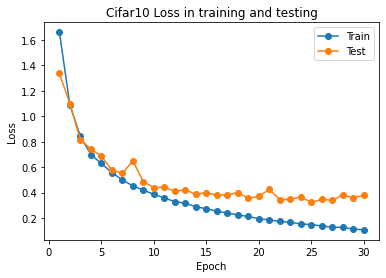

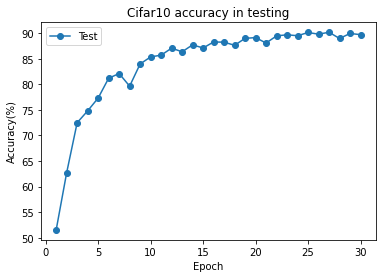

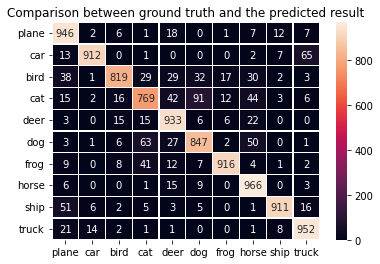

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


# VGG16 and VGG19 have similar accuracy, however VGG16 has a faster speed
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = self._make_layers()
        self.classifier = nn.Linear(512, 10)
    
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self):
        layers = []
        # init in_channel to 3
        in_channels = 3
        # use for to make layer instead of set many unique layer
        # nn module cannot reuse layer, because internal instance cannot change  
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                # 每一層都是conv2d + batchnorm2d + relu
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        # 最後一層加avgpool
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
# 正交化(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# import ssl to ssl certificate
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

trainset = datasets.CIFAR10(
    root='../data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(
    root='../data', train=False, download=True, transform=transform_test)
    
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
model = VGG16()

model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

# use Adam instead of SGD because Adam has better accuracy in the first 30 epoch
optimizer = optim.Adam(model.parameters(),lr=0.001, 
            betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

tot_train_loss = [[], []]
# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # use cross entropy in cifar10
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if(total == 50000):
            tot_train_loss[0].append(epoch)
            tot_train_loss[1].append(train_loss/len(trainloader))
            print('TrainEpoch: %d | Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (epoch, train_loss/(batch_idx+1), (100.*correct)/total, correct, total))
    
    
tot_test_loss = [[], []]
tot_test_acc = [[], []]
ground_truth = []
predicted_result = []

def test(epoch):
    global best_acc
    global ground_truth
    global predicted_result
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            
            test_loss += loss.item()
            _, predicted = output.max(1)
            if(epoch == 30):
                predicted_result.extend(predicted.to('cpu').numpy())
                ground_truth.extend(target.view_as(predicted).to('cpu').numpy())
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            if(total == 10000):
                tot_test_loss[0].append(epoch)
                tot_test_loss[1].append(test_loss/(batch_idx+1))
                tot_test_acc[0].append(epoch)
                tot_test_acc[1].append((100.*correct)/total)
                print('TestEpoch: %d | Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (epoch, test_loss/(batch_idx+1), (100.*correct)/total, correct, total))

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
for epoch in range(1, 31):
    train(epoch)
    test(epoch)
    scheduler.step()

# plot
# plot Loss
plt.plot(tot_train_loss[0], tot_train_loss[1],'-o')
plt.plot(tot_test_loss[0], tot_test_loss[1], '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.title('Cifar10 Loss in training and testing')
plt.show()

#plot Accuracy
plt.plot(tot_test_acc[0], tot_test_acc[1], '-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.legend(['Test'])
plt.title('Cifar10 accuracy in testing')
plt.show()

#plot last test confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure()
x_axis_labels = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck'] # labels for x-axis
y_axis_labels = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck'] # labels for y-axis

ax = sns.heatmap(confusion_matrix(ground_truth, predicted_result), xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, linewidth=0.3, fmt='d')
plt.title('Comparison between ground truth and the predicted result')
plt.show()